# Introduction
This is the random forest learner associated with Voter Analysis.
Please be sure to run DataCleaning.ipynb first to prepare the data

## Imports
Import libraries and write settings here.

In [1]:
from fastai.tabular import *
from fastai import *

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

# Lets see what version of fastai we are using
# !conda list | grep -E "fastai|pytorch"

# Load df_s and catagorical and continuous column names
If either of the following fail then please be sure to run DataCleaning.ipynb first to prepare the data

In [2]:
df_s = pd.read_feather('tmp/df_s')
# df_s.T

In [3]:
with open('tmp/catcont.json') as f:
    data1 = json.load(f)
    res_cont = data1[0]
    res_cat = data1[1] 
    columns_dep_var = data1[2][0]
    
# res_cont
# res_cat

In [4]:
#remove the dependant variable
res_cont = [x for x in res_cont if x not in columns_dep_var]
res_cat = [x for x in res_cat if x not in columns_dep_var]

# Create and Train Model

## Create databunch

In [5]:
#convert trumpgevote to long (otherwise fit fails)
df_s[columns_dep_var] = df_s[columns_dep_var].astype('int64');

In [6]:
# split out train/test sets
from sklearn.model_selection import train_test_split

train,tst = train_test_split(df_s, test_size=0.1)
print(str(len(train)))
print(str(len(tst)))

36801
4089


In [7]:
#how many raw records
len(df_s)

40890

In [8]:
#run these on every row
procs = [FillMissing, Categorify, Normalize]

In [9]:
#get a tabular learner for the test set for the model (required to be in tabular list format)
test_tl = TabularList.from_df(tst.copy(),  cat_names=res_cat, cont_names=res_cont,procs=procs)
len(test_tl)

# id(test_tl)
# test_tl.__repr__()

4089

In [10]:
#all this to get a random list of validation indexes
from numpy import random

#generate a list of all indexes
i = list(range(len(train)))

#shuffle it
random.shuffle(i)

#get number of indexes corresponding to val percentage
number = int(len(i)*.1)

#select validation indexes
val_idx=i[:number]
max(val_idx)
number
len(val_idx)

36780

3680

3680

In [11]:
data = (TabularList.from_df(train,  cat_names=res_cat, cont_names=res_cont, procs=procs)
                           .split_by_idx(val_idx)
                           .label_from_df(cols=columns_dep_var)
                           .add_test(test_tl)
                           .databunch())

# data.show_batch(rows=50)

## Create a learner

In [12]:
#create a learner
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

## Find Learning rate
The following 2 lines run the model on a linearly increasing learning rate.  Choose a rate where the loss is falling the fastest. (Where the red dot is)

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


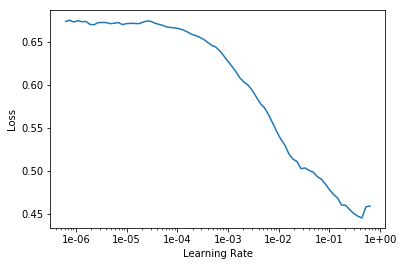

In [14]:
learn.recorder.plot()

## Fit the data

In [15]:
#plug the Learning rate corresponding to the red dot above into LR, choose number epochs, then fit
num_cycles=7
max_lr=3e-3  #choose from above
learn.fit_one_cycle(cyc_len=num_cycles,max_lr=max_lr, wd=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,0.227550,0.203868,0.917391,00:03
1,0.212822,0.200164,0.921467,00:03
2,0.217344,0.198765,0.919565,00:03
3,0.228068,0.192369,0.923098,00:03
4,0.209134,0.186175,0.923641,00:03
5,0.198835,0.183157,0.925000,00:03
6,0.195020,0.182945,0.925000,00:03


In [16]:
#old way of fitting, using a guess at learning rate
# learn.fit(epochs=7, lr=1e-2)

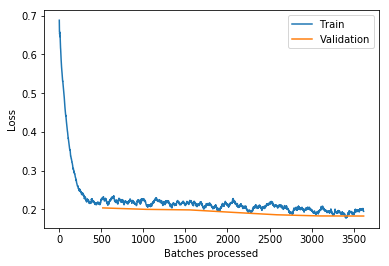

In [17]:
learn.recorder.plot_losses()

## Save model

In [18]:
os.makedirs('models', exist_ok=True)
learn.save(file='VA_NeuralNet_model')

# Test the model on test data

## Get a list of correct labels

In [19]:
#lets get a correct list of all the test labels
targets = [int(item['cc.trumpgevote']) for item in test_tl]

In [20]:
def eval_accuracy(preds,targs):
    totals = len(preds)
    matches = 0
    for x in zip(preds,targs):
        if x[0]==x[1]:
            matches+=1
    print(f"Got {matches} right out of {totals} samples, Accuracy is {matches/totals}")

## The long, very slow way.  One at a time

In [21]:
learn.load(file='VA_NeuralNet_model');

In [23]:
# infer 1 at a time
preds1 = tst.apply(learn.predict, axis=1)

#following does not work for some reason, maybe because of tabular list?
# preds1=[]
# for item in test_long[:500]:
#     pred_class,pred, _ = learn.predict(item)
#     preds1.append(pred.item())
# # len(preds1)
# # preds1

In [24]:
preds2 = [x[0].obj for x in preds1.values]
# type(preds2)
# preds2

In [25]:
eval_accuracy(preds2,targets)

Got 3757 right out of 4089 samples, Accuracy is 0.9188065541697237


## The easy, fast batched way
However note that get_preds does not return the labels as its second param as it indicates in documentation, bug in FastaAI?  

In [27]:
learn.load(file='VA_NeuralNet_model');

In [28]:
#WARNING THE FOLLOWING CALL, get_preds DOES NOT RETURN CORRECT LABELS AS the fastai DOCS IMPLY
predictions, _ = learn.get_preds(DatasetType.Test)

# type(predictions)
# predictions.tolist()[:10]
#targets.tolist()[:100]

In [29]:
#find index of largest output
preds=[torch.argmax(x).item() for x in predictions]
# preds

In [30]:
eval_accuracy(preds,targets)

Got 3757 right out of 4089 samples, Accuracy is 0.9188065541697237


# Results
Show graphs and stats here

# Conclusions and Next Steps
This model is 92% accurate with no data tweaks

# Scratch

In [31]:
#all the same size?
len(test_tl)
len(preds)
len(preds1)
len(targets)

4089

4089

4089

4089

In [ ]:
# data = test[0]
# data[31]
# type(data)
# data.shape
# tmp=learn.predict(data)
# len(tmp)
# out,pred,res=tmp

# out
# pred
# res

# # len(out)
# # len(pred)
# len(res)